0%                          100%
[##                            ] | ETA: 00:00:02

Data_handler: Fetched 2858 candles for each symbols
Strategy DC_20x20, lookback: 20x20, atr_stop 3.0
Strategy DC_50x30, lookback: 50x30, atr_stop 3.0
Strategy DC_100x50, lookback: 100x50, atr_stop 3.0
Strategy DC_200x100, lookback: 200x100, atr_stop 3.0


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:04


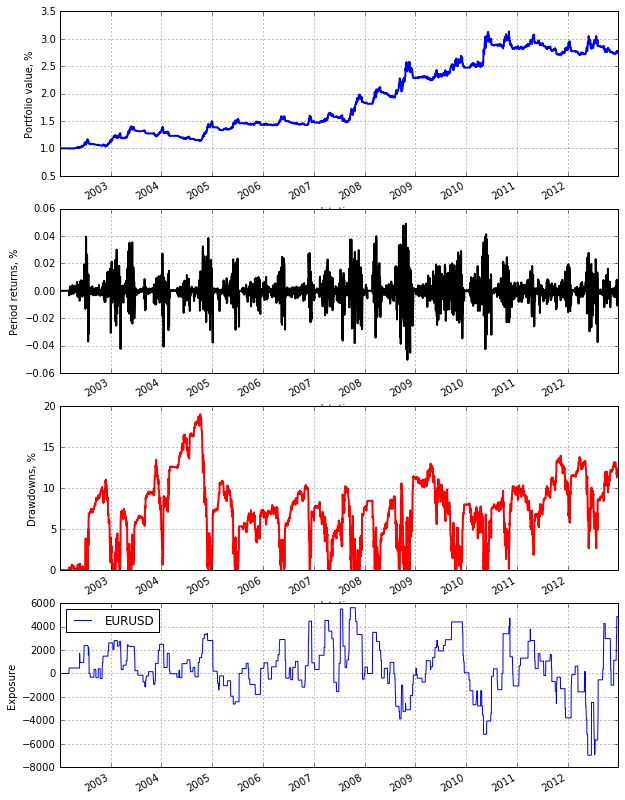

,Base Stats
#Trades,233.000000
CAGR(%),9.673742
Avg trade(R),0.472355
Daily Sharpe,0.710371


In [1]:
import queue
import matplotlib.pyplot as plt
from datetime import datetime

from broker.historical_data_handler import DatabaseDataHandler
from broker.execution_handler import SimulatedExecution
from portfolio import Portfolio
from backtest import BacktestEngine
from broker.account import SimulatedAccount
from strategies.donchian_breakout import DonchianBreakout
from strategies.RSI_MOM_1 import RSI_Trading_Strategy

%matplotlib inline

#PARAMETERS
symbol_list= ['EURUSD']
risk= 0.06
equity = 1000.0
leverage = 20
start_date= datetime(2002,1,1)
end_date= datetime(2012,12,31)


#
events_queue = queue.Queue()
account = SimulatedAccount(equity,leverage,'USD')
prices = DatabaseDataHandler(events_queue=events_queue, symbol_list=symbol_list,account=account,db_adress='localhost',
                             timeframe='D1', start_date=start_date,end_date=end_date,data_vendor='FX')
#"""
strategy_1 = DonchianBreakout(prices,events_queue, entry_lookback=20, exit_lookback=20, atr_stop=3.,TP_atr=5.,name='DC_20x20')
strategy_2 = DonchianBreakout(prices,events_queue, entry_lookback=50, exit_lookback=30, atr_stop=3.,TP_atr=5.,name='DC_50x30')
strategy_3 = DonchianBreakout(prices,events_queue, entry_lookback=100, exit_lookback=50, atr_stop=3.,TP_atr=5.,name='DC_100x50')
strategy_4 = DonchianBreakout(prices,events_queue, entry_lookback=200, exit_lookback=100, atr_stop=3.,TP_atr=5.,name='DC_200x100')

strategy_5 = RSI_Trading_Strategy(prices,events_queue,rsi_lookback=30, rsi_trigger_offset=37)
#"""
strategy_6 = RSI_Trading_Strategy(prices,events_queue,rsi_lookback=5, rsi_trigger_offset=10)
strategies = [strategy_1,strategy_2,strategy_3,strategy_4,strategy_5,strategy_6]
#strategies=[strategy_6]



portfolio = Portfolio(events_queue=events_queue, prices=prices,account=account,strategies=strategies,risk_per_trade = risk)
portfolio.open_trades.clear()

execution = SimulatedExecution(events_queue,prices)
backtest = BacktestEngine(events_queue, prices, execution,account, portfolio, strategies)

backtest.backtest_trading()
backtest.stats.plot_performance()
backtest.stats.output_base_stats()

# Analysis

In [2]:
backtest.stats.output_full_stats()

,All Trades,Long only,Short only
#Trades,233,134,99
CAGR(%),9.67374,NaN,NaN
Avg trade(R),0.472355,0.6223,0.269399
Daily Sharpe,0.710371,NaN,NaN
Max Drawdown(%),18.9614,NaN,NaN
Avg Duration,58 days 15:57:56.394849,62 days 07:52:50.149253,53 days 16:58:10.909090
Exposure %,96.501,57.5227,38.9783
Win Rate %,53.6481,0.589552,0.464646
Avg Win,1.74725,1.76544,1.71602
Avg Loss,-1.00322,-1.01966,-0.986155


In [3]:
trades = backtest.stats.trades
trades_per_years = trades.open_date.groupby(trades.open_date.dt.year).count()
ce = backtest.stats.cagr /trades_per_years.mean() *100
print('Cost efficiency %0.2f' %ce)



Cost efficiency 0.46


In [4]:
from scipy import stats
import numpy as np

def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

hist = backtest.stats.history
print("R-squared %0.2f" %rsquared(np.arange(len(hist.equity)),hist.equity))

R-squared 0.92
